In [7]:
# Library of my own functions
import sys
sys.path.append("../src/")
import my_functions

# Libraries to deal with dataframes, vectors and formats
import pandas as pd
import numpy as np
import pickle as pkl

# sklearn to do Grid Search & ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import RFECV

# keras for deep learning model creation
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.optimizers import Adam

# Plotting libraries to understand the models
import matplotlib.pyplot as plt
import seaborn as sns
import logging
logging.getLogger().setLevel(logging.CRITICAL) # Avoids no critical warnings
plt.rcParams['figure.figsize'] = [20, 4] # Change figure size of the cell of the notebook

# 1. Train Model

##  1.1 Create Features and Target

In [8]:
df = pd.read_csv("../data/preprocess/pima_standard_scaler.csv")
X = df.iloc[:, 0:8]
y = df["Outcome"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## 2.2 Logistic Regression 

#### 2.2.1  Train

In [13]:
log_reg = LogisticRegression() # Initialize Logistic Regression
rfecv = RFECV(estimator=log_reg, step=1, cv=10, scoring='f1_weighted')
rfecv.fit(X_train, y_train)

RFECV(cv=10, estimator=LogisticRegression(), scoring='f1_weighted')

#### 2.2.2 Explore the model

Optimal number of features: 3
Selected features: ['Pregnancies', 'Glucose', 'BMI']


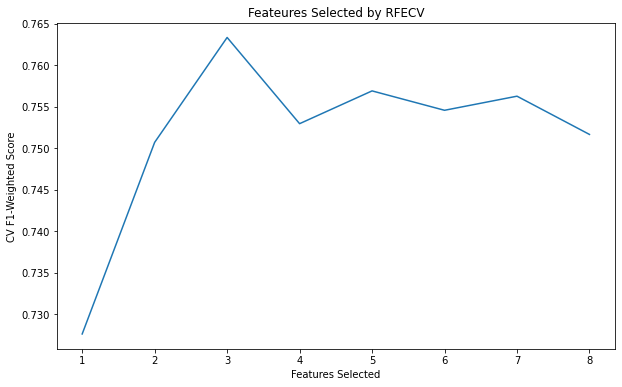

In [14]:
print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X_train.columns[rfecv.support_]))
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Features Selected")
plt.ylabel("CV F1-Weighted Score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title("Feateures Selected by RFECV")
plt.show()

#### 2.2.3  Make predictions in training and validation

In [10]:
train_file = "../data/features/train_raul.pkl"
val_file = "../data/features/val_raul.pkl"
output_file = "../data/predictions/logreg_rfecv.csv"
model = rfecv

my_functions.save_predictions(train_file, val_file, output_file, model, format_type = "pickle" ,index_column = "PassengerId", target_column = "Survived")

#### 2.2.4  Save the model

In [11]:
with open('../models/features_raul/logreg_rfecv.pkl','wb') as f:
    pkl.dump(rfecv,f)

## 2.3 Random Forest

#### 2.3.1  Create Grid for Hyperparameter Selection

In [8]:
# Initialize Random Forest
rf = RandomForestClassifier()

In [9]:
n_estimators = [100, 300, 500, 1000, 2000] # Number of trees in random forest
max_depth = [None] # Maximum number of levels in tree
max_features =  [int(x) for x in np.linspace(start = 1, stop = 40, num = 5)] # Number of features to consider at every split
min_samples_split = [2, 3, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 3, 10] # Minimum number of samples required at each leaf node
bootstrap = [False] # Method of selecting samples for training each tree
criterion = ["gini"]

rf_grid = {"n_estimators" :n_estimators,
            "max_depth": max_depth,
            "max_features": max_features,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf,
            "bootstrap": bootstrap,
            "criterion": criterion}

gs_rf = GridSearchCV(rf, param_grid = rf_grid, cv=5, scoring="f1_weighted", n_jobs= 4, verbose = 1)

#### 2.3.2  Train

In [10]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   40.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  7.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 14.4min
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed: 22.5min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [None],
                         'max_features': [1, 10, 20, 30, 40],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [100, 300, 500, 1000, 2000]},
             scoring='f1_weighted', verbose=1)

In [11]:
# Best Model
rf_best = gs_rf.best_estimator_

# Best score
gs_rf.best_score_

0.8411160150171861

#### 2.3.3  Exploring the Model

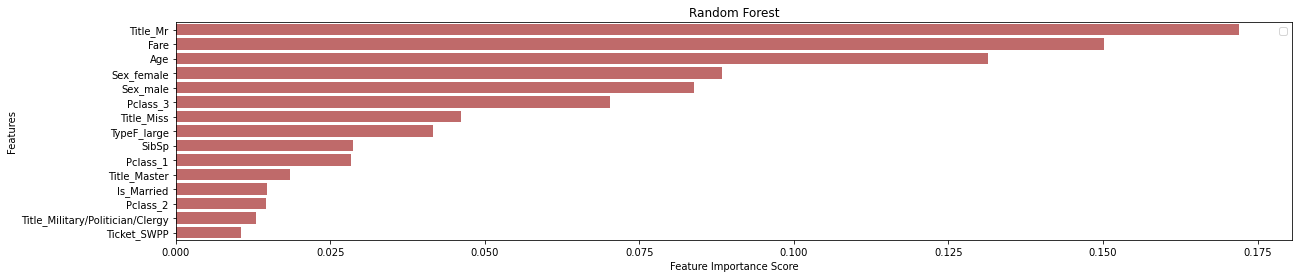

<module 'matplotlib.pyplot' from '/home/raul/anaconda3/envs/roche/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [6]:
my_functions.plot_feature_importance(random_forest, X_train, title="Random Forest")

#### 2.3.4  Make predictions in training and validation

In [12]:
train_file = "../data/features/train_raul.pkl"
val_file = "../data/features/val_raul.pkl"
output_file = "../data/predictions/features_raul/random_forest.csv"
model = rf_best

my_functions.save_predictions(train_file, val_file, output_file, model, format_type = "pickle" ,index_column = "PassengerId", target_column = "Survived")

#### 2.3.5  Save the model

In [13]:
with open('../models/features_raul/random_forest.pkl','wb') as f:
    pkl.dump(rf_best,f)

## 2.4 Gradient Boosting

#### 2.4.1  Create Grid for Hyperparameter Selection

In [14]:
gbc = GradientBoostingClassifier()

In [15]:
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100, 200, 300, 500, 700],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gs_gbc = GridSearchCV(gbc, param_grid = gb_param_grid, cv=10, scoring="f1_weighted", n_jobs= 4, verbose = 1)

#### 2.4.2  Train

In [16]:
gs_gbc.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed:  3.4min finished


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'loss': ['deviance'], 'max_depth': [4, 8],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [100, 200, 300, 500, 700]},
             scoring='f1_weighted', verbose=1)

In [17]:
# Best Model
gbc_best = gs_gbc.best_estimator_

# Best score
gs_gbc.best_score_

0.8381736705739765

#### 2.4.3  Exploring the model

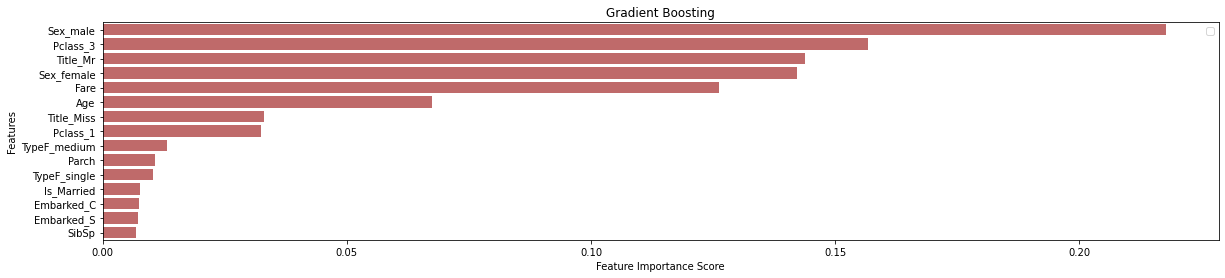

<module 'matplotlib.pyplot' from '/home/raul/anaconda3/envs/roche/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [7]:
my_functions.plot_feature_importance(gradient_boosting, X_train, title="Gradient Boosting")

#### 2.4.4  Make predictions in training and validation

In [18]:
train_file = "../data/features/train_raul.pkl"
val_file = "../data/features/val_raul.pkl"
output_file = "../data/predictions/features_raul/gradient_boosting.csv"
model = gbc_best

my_functions.save_predictions(train_file, val_file, output_file, model, format_type = "pickle" ,index_column = "PassengerId", target_column = "Survived")

#### 2.4.5  Save the model

In [19]:
with open('../models/features_raul/gradient_boosting.pkl','wb') as f:
    pkl.dump(gbc_best,f)

## 2.5 ADA Boosting

#### 2.5.1  Create Grid for Hyperparameter Selection

In [20]:
dtc = DecisionTreeClassifier()

ada_dtc = AdaBoostClassifier(dtc, random_state=7)

In [21]:
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gs_ada_dtc = GridSearchCV(ada_dtc, param_grid = ada_param_grid, cv=10, scoring="f1_weighted", n_jobs= 4, verbose = 1)

#### 2.5.2  Train

In [22]:
gs_ada_dtc.fit(X_train,y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   16.4s finished


GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=7),
             n_jobs=4,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__splitter': ['best', 'random'],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,
                                           1.5],
                         'n_estimators': [1, 2]},
             scoring='f1_weighted', verbose=1)

In [23]:
# Best Model
gs_ada_best = gs_ada_dtc.best_estimator_

# Best score
gs_ada_dtc.best_score_

0.815866948093697

#### 2.5.3  Exploring the model

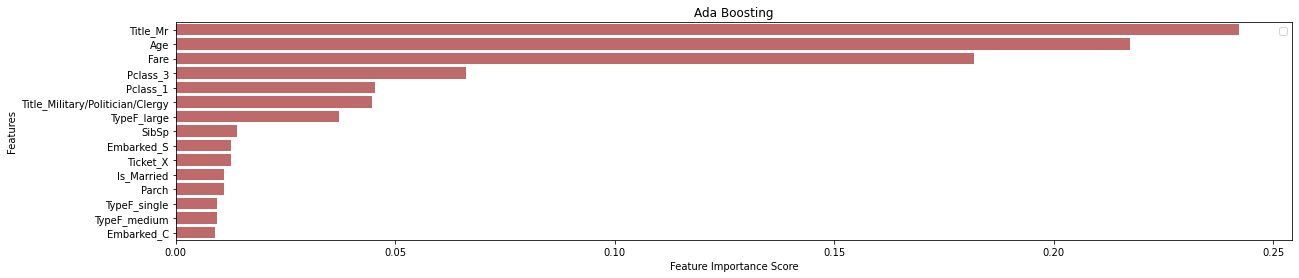

<module 'matplotlib.pyplot' from '/home/raul/anaconda3/envs/roche/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [8]:
my_functions.plot_feature_importance(ada_boosting, X_train, title="Ada Boosting")

#### 2.5.4  Make predictions in training and validation

In [24]:
train_file = "../data/features/train_raul.pkl"
val_file = "../data/features/val_raul.pkl"
output_file = "../data/predictions/features_raul/ada_boosting.csv"
model = gs_ada_best

my_functions.save_predictions(train_file, val_file, output_file, model, format_type = "pickle" ,index_column = "PassengerId", target_column = "Survived")

#### 2.5.5  Save the model

In [25]:
with open('../models/features_raul/ada_boosting.pkl','wb') as f:
    pkl.dump(gs_ada_best,f)

## 2.6 SVC

#### 2.6.1  Create Grid for Hyperparameter Selection

In [26]:
svc = SVC(probability=True)

In [27]:
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100, 200,300, 1000]}

gs_sv = GridSearchCV(svc, param_grid = svc_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)

#### 2.6.2  Train the model

In [28]:
gs_sv.fit(X_train, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.8s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   57.5s finished


GridSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=4,
             param_grid={'C': [1, 10, 50, 100, 200, 300, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [29]:
# Best Model
sv_best = gs_sv.best_estimator_

# Best score
gs_sv.best_score_

0.8052314814814816

#### 2.6.3  Make predictions in training and validation

In [30]:
train_file = "../data/features/train_raul.pkl"
val_file = "../data/features/val_raul.pkl"
output_file = "../data/predictions/features_raul/svc.csv"
model = sv_best

my_functions.save_predictions(train_file, val_file, output_file, model, format_type = "pickle" ,index_column = "PassengerId", target_column = "Survived")

#### 2.6.4  Save the model

In [31]:
with open('../models/features_raul/svc.pkl','wb') as f:
    pkl.dump(sv_best,f)

## 2.7 Deep Learning 

I try to do a deep learning approach also because I really like Deep Learning. I even made the whole specialization of Deep Learning in Coursera (100 hours) and my master thesis was about classifying different Respiratory Sounds with DL.

However, there is a problem in the way I have to encode the data to feed it to the model. I did the one fitting, but the model was not learning anything. I put the code so you can evaluate that I can also use Keras and TensorFlow.

#### 2.7.1 Create the Model

In [12]:
# Create the model
input_dim = X_train.shape[1]

model = Sequential(
    [
        Dense(256, activation="relu", input_shape=(input_dim,)),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(2, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               12288     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 514       
Total params: 144,386
Trainable params: 144,386
Non-trainable params: 0
________________________________________________

In [13]:
optimizer = Adam(lr=0.000001)
auc = tf.keras.metrics.AUC()
metrics = ['accuracy', auc] 
loss_function = 'binary_crossentropy'

# Compile model
model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

#### 2.7.2 Train the model

In [14]:
# Establishing Callbacks
csv_logger = CSVLogger("../models/deep_learning/history.csv", append=True) 
checkpoint = ModelCheckpoint("../models/deep_learning/dl_model.h5", monitor='val_auc_1', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') 
early_stopping = EarlyStopping(monitor='val_auc', min_delta=0, patience=20, verbose=1, mode='auto')

In [6]:
epochs = 500 # Number of epochs to train (We put this number high, because we have the early stopping callback)
model.fit(X_train, y_train, validation_data = (X_val, y_val), callbacks = [csv_logger, checkpoint, early_stopping], epochs=epochs)

#### 2.7.3 Evaluate the Training

In [16]:
input_file = "../models/deep_learning/history.csv"
history = pd.read_csv(input_file)

# Tidy the df so it become easier to plot
history['epoch'] = history.index
history = pd.melt(history, id_vars=['epoch'])
history.rename(columns={"variable":"metric"},inplace=True)

Text(0.5, 1.0, 'Loss Plot')

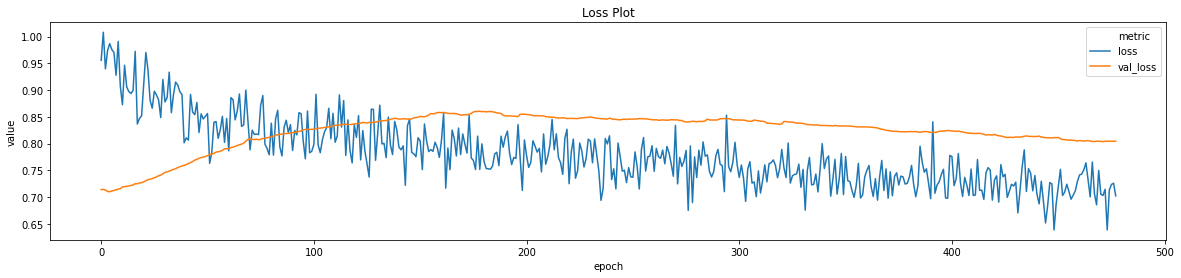

In [18]:
# Loss Plot
loss_df = history[history['metric'].isin(['val_loss','loss'])]
sns.lineplot(x='epoch', y='value', hue='metric', data=loss_df)
plt.title("Loss Plot")

-The value of val_loss and loss is increasing while it must decrease that why I said it is not learning. The same happens with accuracy and auc, they remain flat